# RBPF with FloRES

In [2]:
import jax
import numpy as np
from time import time
import seaborn as sns
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from functools import partial
from jaxopt import ProjectedGradient

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from bayesopt import test_functions, eval_fn, agents
from rebayes_mini.methods import low_rank_last_layer as lrll

/home/gerardoduran/miniconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/home/gerardoduran/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
sns.set_palette("colorblind")
plt.rcParams["figure.figsize"] = (7.2, 4.2)

In [6]:
jnp.set_printoptions(suppress=False, precision=8, linewidth=200)

In [7]:
%config InlineBackend.figure_format = "retina"

In [8]:
def plot_hist(ax, runs, **kwargs):
    steps = np.arange(len(runs[0]))
    med_run = np.quantile(runs, 0.5, axis=0)
    # med_run = np.mean(runs, axis=0)
    lbound = np.quantile(runs, 0.25, axis=0)
    ubound = np.quantile(runs, 0.75, axis=0)

    
    ax.plot(med_run, **kwargs)
    ax.fill_between(steps, lbound, ubound, alpha=0.4)

# Setup

In [9]:
key = jax.random.PRNGKey(3141)
key_init, key_run = jax.random.split(key)

In [10]:
n_runs = 3
keys = jax.random.split(key_run, n_runs)

In [11]:
n_steps = 600
dim = 200
query_method = "grad"
X_init = jnp.ones((1, dim))
objective_fn = test_functions.init_fn_draw_nn(key_init, dim)

In [12]:
lbound, ubound = 0.0, 1.0

## FLoRES

In [13]:
agent, bel_init_fn = agents.load_ll_lrkf_agent(
    X_init,
    # rank=100, cov_hidden=1e-4, cov_last=0.01, dynamics_last=0.0,
    rank=50, cov_hidden=1e-4, cov_last=0.005, dynamics_last=0.0,
)

In [14]:
%%time
time_init = time()
runs_flores = eval_fn.test_runs(
    keys, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, dim, query_method
)
runs_flores = jax.tree.map(np.array, runs_flores)
time_flores = time() - time_init

CPU times: user 29.8 s, sys: 442 ms, total: 30.2 s
Wall time: 21.5 s


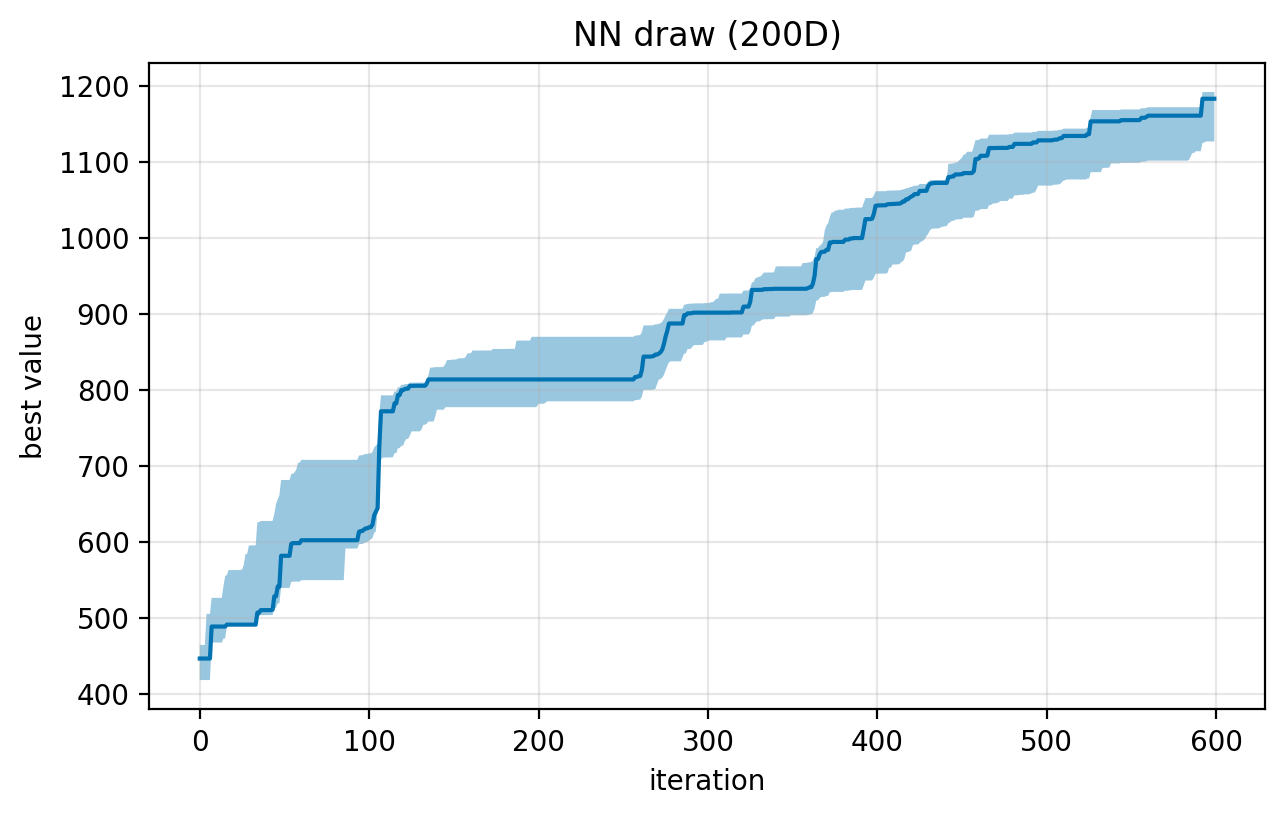

In [15]:
fig, ax = plt.subplots()
plot_hist(ax, runs_flores["y_best"])
plt.title(f"NN draw ({dim}D)")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.grid(alpha=0.3)
# plt.xticks(np.arange(0, 110, 10));

## RBPF + FLoRES

In [19]:
agent, bel_init_fn = agents.load_ll_lrkf_rbpf_agent(
    X_init,
    # rank=100, cov_hidden=1e-4, cov_last=0.01, dynamics_last=0.0,
    rank=50, cov_hidden=1e-4, cov_last=0.01, dynamics_last=0.0,
    num_particles=5,
)

In [20]:
%%time
time_init = time()
runs_flores_rbpf = eval_fn.test_runs(
    keys, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, dim, query_method
)
runs_flores_rbpf = jax.tree.map(np.array, runs_flores_rbpf)
time_flores_rbpf = time() - time_init

CPU times: user 40 s, sys: 957 ms, total: 40.9 s
Wall time: 23.5 s


## Comparison

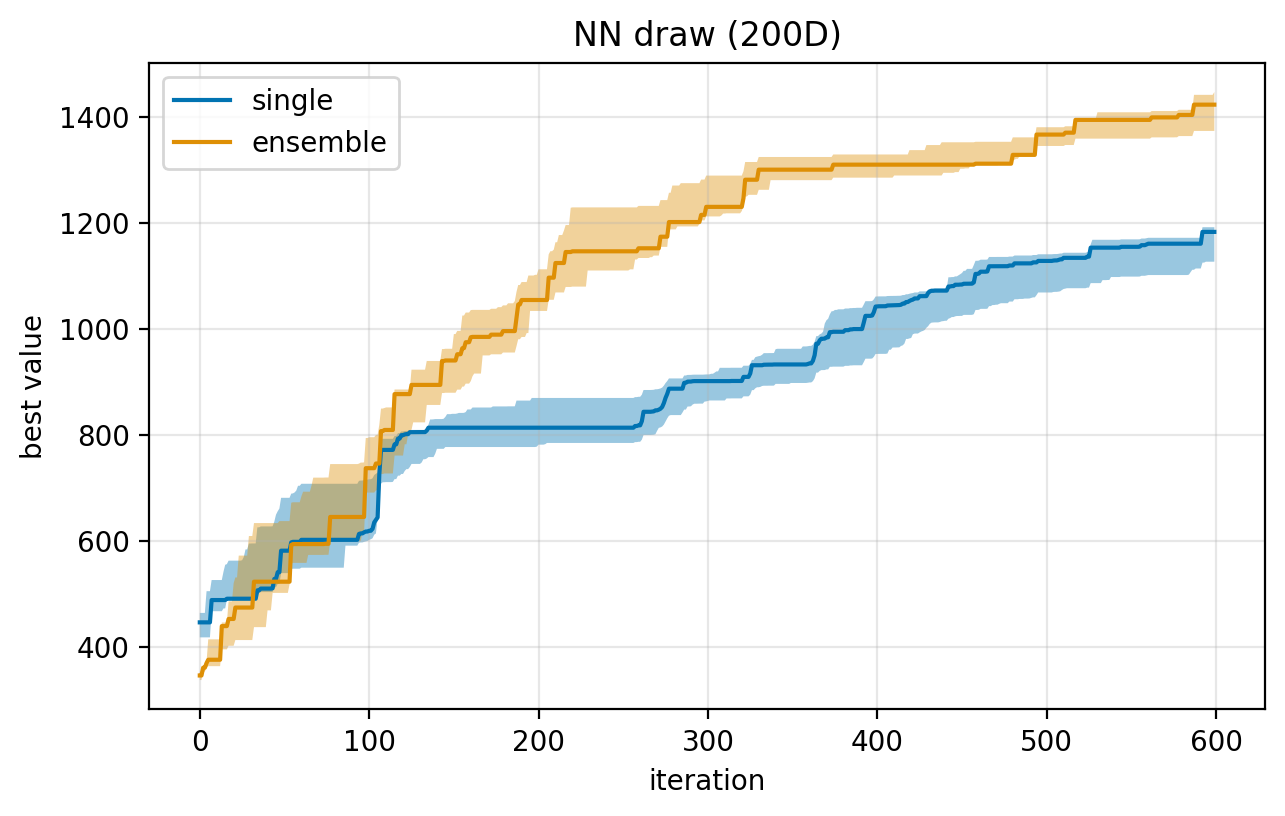

In [125]:
fig, ax = plt.subplots()
plot_hist(ax, runs_flores["y_best"], label="single")
plot_hist(ax, runs_flores_rbpf["y_best"], label="ensemble")
plt.title(f"NN draw ({dim}D)")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.legend()
plt.grid(alpha=0.3)
# plt.xticks(np.arange(0, 110, 10));

## Structs

In [65]:
from chex import dataclass

@dataclass
class TestState:
    n_particles: int
    values: jax.Array

In [66]:
n_particles = 5
state = TestState(n_particles=n_particles, values=jnp.arange(n_particles))

In [67]:
from jax.tree_util import tree_structure

In [68]:
state_dict = {"n_particles": n_particles, "values": jnp.arange(n_particles)}
state_dict

{'n_particles': 5, 'values': Array([0, 1, 2, 3, 4], dtype=int32)}

In [69]:
tree_structure(state)

PyTreeDef(CustomNode(TestState[('n_particles', 'values')], [*, *]))

In [70]:
tree_structure(state_dict)

PyTreeDef({'n_particles': *, 'values': *})

## Test1

In [71]:
in_axes = ({"n_particles": None, "values": 0}, None)
@partial(jax.vmap, in_axes=in_axes)
def evalfn(bel, x):
    return bel["n_particles"] + bel["values"] * x

In [72]:
evalfn(state_dict, 2.0)

Array([ 5.,  7.,  9., 11., 13.], dtype=float32, weak_type=True)

## Test1

In [73]:
# in_axes = ({"n_particles": None, "values": 0}, None)
in_axes = (TestState(n_particles=None, values=0), None)
@partial(jax.vmap, in_axes=in_axes, out_axes=TestState(n_particles=None, values=0))
def evalfn(bel, x):
    return bel.replace(n_particles=n_particles + x, values=bel.values + x)

In [74]:
struct = tree_structure(state)

In [75]:
evalfn(state, 2.0)

TestState(n_particles=7.0, values=Array([2., 3., 4., 5., 6.], dtype=float32, weak_type=True))

## Single ensemble

In [76]:
agent, bel_init_fn = agents.load_ll_lrkf_rbpf_agent(
    X_init,
    # rank=100, cov_hidden=1e-4, cov_last=0.01, dynamics_last=0.0,
    rank=50, cov_hidden=1e-4, cov_last=0.005, dynamics_last=0.0,
    num_particles=10,
)

In [77]:
%%time
time_init = time()
bel, run = eval_fn.test_run(
    key, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, dim, query_method
)
run = jax.block_until_ready(run)
time_flores_rbpf = time() - time_init

CPU times: user 25.9 s, sys: 564 ms, total: 26.5 s
Wall time: 16.4 s


In [81]:
bel.mean_hidden

Array([-0.05379863,  0.03634344, -0.02746083, ..., -0.00359748, -0.13700934,  0.14787821], dtype=float32)

In [78]:
bel.mean_last

Array([[-1624.644    ,    -2.4895782,   152.32788  , ...,    54.185017 ,  -400.17923  ,   111.19188  ],
       [-1603.3113   ,   -18.335585 ,    98.17399  , ...,    68.168144 ,  -405.8622   ,   140.72372  ],
       [-1604.1058   ,   -18.608612 ,   123.34876  , ...,    86.457436 ,  -402.59326  ,   145.36063  ],
       ...,
       [-1625.8877   ,   -23.660933 ,   126.075676 , ...,    63.0961   ,  -429.18546  ,   152.65388  ],
       [-1626.9747   ,   -26.004906 ,   120.64583  , ...,    80.25907  ,  -437.35855  ,   176.08157  ],
       [-1600.6487   ,   -20.718292 ,   129.02666  , ...,    61.06295  ,  -419.59723  ,   155.60858  ]], dtype=float32)